# Projeto LLM PEDRO HENRIQUE VELOSO FERNANDES
## Instruction Tuning com GPT-2 e Avaliação com LLM-as-a-Judge
Este notebook centraliza as etapas de análise e experimentação do projeto com modelos de linguagem.

Propósitos principais:

- Investigar e preparar os conjuntos de dados através de llms e datasets prontos

- Realizar o ajuste fino dos modelos e medir seu desempenho

- Produzir relatórios e criar visualizações dos resultados

# Imports

In [1]:
!pip install llms-from-scratch
!pip install kaggle
!pip install langchain langchain-community langchain-aws ragas
!pip install boto3
!pip install rapidfuzz
!pip install langchain-openai
!pip -q install -U deepeval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 91.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 126.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 84.5 MB/s  0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Unins

In [2]:
import os
import json
import re
import time
import random
import copy
import requests
from pathlib import Path
from functools import partial
from importlib.metadata import version

import boto3
import kagglehub
import openai
import tiktoken
import torch
import pandas as pd

from google.colab import userdata
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

from langchain_aws import ChatBedrockConverse, BedrockEmbeddings
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import DirectoryLoader, TextLoader

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper, OpenAIEmbeddings
from ragas.testset import TestsetGenerator
from ragas.testset.graph import KnowledgeGraph, Node, NodeType
from ragas.testset.persona import Persona
from ragas.testset.transforms import default_transforms, apply_transforms
from ragas.testset.transforms import HeadlinesExtractor, HeadlineSplitter, KeyphrasesExtractor
from ragas.testset.transforms.extractors import (
    EmbeddingExtractor,
    HeadlinesExtractor,
    SummaryExtractor,
)
from ragas.testset.transforms.extractors.llm_based import (
    NERExtractor,
    ThemesExtractor,
)
from ragas.testset.synthesizers.single_hop.specific import (
    SingleHopSpecificQuerySynthesizer,
)

from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams

from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import (
    download_and_load_gpt2,
    load_weights_into_gpt,
    calc_loss_loader,
    train_model_simple,
    plot_losses,
    generate,
    text_to_token_ids,
    token_ids_to_text,
)


/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


# Dataset

Baixando e criando os datasets utilizados pelo gpt2 para fine tunning:
- CNN:
  - Summarization (**summarization_cnn_instruction_data.json**): utilizei o dataset original adptando para o modelo usado para treino do Sebastian.
  - Question and answer (**qa_cnn_instruction_data.json**): criei o dataset com base no transform do ragas, que permite ser fiel ao conteudo fornecido sem alucinação.
- SST-2(**sst2_instruction_data.json**):
  - Sentiment analysis: utilizei o dataset original adptando para o modelo usado para treino do Sebastian.
- AG NEWS(**agnews_instruction_data.json**):
  - Classification: a partir do "highlights" do artigo, foi possível extrair as palavras chaves para fazer classificação.
- SQuaAD(**qa_squad_instruction_data.json**):
  - Question and answer: Utilizei o dataset original adptando para o modelo usado para treino do Sebastian, porem como o modelo é relativamente pequeno, não teve resultados satisfatorios no treinamento, com o modelo grande com validation loss de 2.3


In [3]:
OUTPUT_DIR = "/content"
def save_json(path, data_iter):
    with open(path, "w", encoding="utf-8") as f:
        f.write("[\n")
        first = True
        count = 0
        for item in data_iter:
            if not first:
                f.write(",\n")
            json.dump(item, f, ensure_ascii=False)
            first = False
            count += 1
        f.write("\n]")
    print(f"{count} exemplos salvos em {path}")

## CNN NEWS

In [ ]:
base_path = kagglehub.dataset_download(
    "gowrishankarp/newspaper-text-summarization-cnn-dailymail",
)
base_path = Path(base_path)
csv_files = {p.name: p for p in base_path.rglob("*.csv")}
csv_path = csv_files.get("test.csv") or next(iter(csv_files.values()))
df = pd.read_csv(csv_path)

expected = {"id", "article", "highlights"}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Colunas faltando: {missing}. Colunas presentes: {list(df.columns)}")

N = 100
subset = df.sample(n=min(N, len(df)), random_state=42).reset_index(drop=True)

out_dir = Path("/content/ragas-cnn-dailymail-dataset")
out_dir.mkdir(parents=True, exist_ok=True)

for i, row in subset.iterrows():
    text = (
        f"# ARTICLE:\n{row['article']}\n\n"
        f"HIGHLIGHTS:\n{row['highlights']}\n"
    )
    (out_dir / f"sample_{i:06d}.txt").write_text(text, encoding="utf-8")

print("Arquivos .txt em:", out_dir, "| qtd:", len(list(out_dir.glob('*.txt'))))

loader = DirectoryLoader(
    str(out_dir),
    glob="**/*.txt",
    loader_cls=TextLoader
)
docs = loader.load()
for document in docs:
    document.metadata['filename'] = document.metadata['source']

print("Docs carregados:", len(docs))
print(docs[0].page_content[:500])


100%|██████████| 503M/503M [00:22<00:00, 23.4MB/s]

Extracting files...


Dataset em: /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2
CSVs encontrados: ['test.csv', 'train.csv', 'validation.csv']
Usando: /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/test.csv
Arquivos .txt em: /content/ragas-cnn-dailymail-dataset | qtd: 100
Docs carregados: 100
# ARTICLE:
Technology: A study found that the majority of older workers did not believe better computer skills would help them in their current job . A generation of older workers are risking redundancy and long-term unemployment because of poor technology skills, it is claimed. Experts said training was ‘heavily geared’ towards young people, meaning many older workers were left behind in the workplace. This left them vulnerable when companies start ‘shedding’ jobs. While older generations often


In [ ]:
len(docs)

100

### QA (CNN)

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get("API_KEY")

In [ ]:
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
openai_client = openai.OpenAI()
generator_embeddings = OpenAIEmbeddings(client=openai_client)

/tmp/ipython-input-300379323.py:6: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))


In [ ]:
transforms = [HeadlinesExtractor(llm=generator_llm), HeadlineSplitter(), NERExtractor(llm=generator_llm)]


In [ ]:
persona_direct_qa_reader = Persona(
    name="Direct Answer Seeker",
    role_description=(
        "Reads news articles to obtain specific facts quickly. "
        "Asks clear and direct questions about the content and expects concise, factual answers. "
        "Focuses on key information such as who, what, when, where, why, and how. "
        "Prefers short, precise responses grounded strictly in the article, "
        "without opinions, background explanations, or unnecessary details. "
        "Typical questions include 'What happened?', 'Who was involved?', "
        "'When did it occur?', 'Where did it take place?', and "
        "'What was the outcome?'."
    )
)

In [ ]:

distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 1.0),
    ]


In [ ]:

generator = TestsetGenerator(
        llm=generator_llm, embedding_model=generator_embeddings, persona_list=[persona_direct_qa_reader]
    )

batch_size = 10
all_datasets = []
er = []
for i in tqdm(range(0, len(docs), batch_size)):
    batch_docs = docs[i:i + batch_size]
    atual = batch_docs[0].metadata["source"]
    print("\n" + atual)

    try:
        dataset_batch = generator.generate_with_langchain_docs(
            batch_docs,
            testset_size=batch_size * 3,
            transforms=transforms,
            query_distribution=distribution
        )

        all_datasets.append(dataset_batch.to_pandas())

    except Exception as e:
        er.append(atual)
        continue

  0%|          | 0/10 [00:00<?, ?it/s]


/content/ragas-cnn-dailymail-dataset6/sample_000000.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/37 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/28 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:45<15:46, 105.12s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000032.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/36 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/30 [00:00<?, ?it/s]

 20%|██        | 2/10 [04:54<20:35, 154.46s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000002.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/40 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/30 [00:00<?, ?it/s]

 30%|███       | 3/10 [07:17<17:24, 149.28s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000089.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/36 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/28 [00:00<?, ?it/s]

 40%|████      | 4/10 [10:00<15:29, 154.88s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000070.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/37 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/24 [00:00<?, ?it/s]

 50%|█████     | 5/10 [12:56<13:32, 162.41s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000081.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/30 [00:00<?, ?it/s]

 60%|██████    | 6/10 [16:26<11:54, 178.65s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000023.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/37 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/28 [00:00<?, ?it/s]

 70%|███████   | 7/10 [18:58<08:29, 169.78s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000011.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/37 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/30 [00:00<?, ?it/s]

 80%|████████  | 8/10 [22:00<05:47, 173.82s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000072.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/42 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/19 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [24:48<02:51, 171.93s/it]


/content/ragas-cnn-dailymail-dataset6/sample_000080.txt


Applying HeadlinesExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 10/10 [27:33<00:00, 165.39s/it]


In [ ]:
df_lgd = pd.concat(all_datasets, ignore_index=True)

cols = ["user_input", "reference_contexts", "reference"]
df_lgd = df_lgd.loc[:, df_lgd.columns.intersection(cols)]
df_lgd

user_input  \
0    What has Esther McVey demanded from Ed Miliban...   
1    Wht did Tory minster Esther McVey say about th...   
2    What did Grant Shapps say about the campaign a...   
3    What did Miss McVey say about Natalie Bennett ...   
4    What challenges has Esther McVey faced in her ...   
..                                                 ...   
268        Who Orlando City play against this weekend?   
269  What has the Brasilian Kaka been doing since l...   
270  What Kaka do after leaving AC Milan and how he...   
271  What mistake involved Jay Pharoah on The Project?   
272  What incident occurred involving Michael Che a...   

                                    reference_contexts  \
0    [ARTICLE: Battleground: Esther McVey, who won ...   
1    [ARTICLE: Battleground: Esther McVey, who won ...   
2    [of jobs created in the economy, two million j...   
3    [of jobs created in the economy, two million j...   
4    [HIGHLIGHTS:\nEsther McVey will not be cowered...   
..                                                 ...   
268  [ARTICLE:\nHe might be the biggest name plying...   
269  [HIGHLIGHTS:\nOrlando City have not won any of...   
270  [HIGHLIGHTS:\nOrlando City have not won any of...   
271  [ARTICLE:\nChannel Ten show The Project has ap...   
272  [ARTICLE:\nChannel Ten show The Project has ap...   

                                             reference  
0    Esther McVey has demanded that Ed Miliband con...  
1    Tory minister Esther McVey said that the attac...  
2    Tory chairman Grant Shapps condemned the campa...  
3    Miss McVey said that she was pleased to see Ni...  
4    Esther McVey has faced 'misogynistic and sexis...  
..                                                 ...  
268  Orlando City will play against Portland Timber...  
269  The Brazilian Kaka has become an instant hero ...  
270  Kaka took to Instagram to give fans a glimpse ...  
271  The Project mistakenly used footage of Jay Pha...  
272  The Project mistakenly used footage of Jay Pha...  

[273 rows x 3 columns]

In [ ]:
data = (
    df_lgd[["user_input", "reference"]]
    .rename(columns={"user_input": "instruction", "reference": "output"})
    .assign(input="")
    [["instruction", "input", "output"]]
    .to_dict(orient="records")
)


In [ ]:

with open("cnn_instruction_data.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

### Sumarrization (CNN)

In [4]:

INPUT_DIR = Path("ragas-cnn-dailymail-dataset")
OUTPUT_FILE = "summarization_cnn_data.json"


article_re = re.compile(r"# ARTICLE:\n(.*?)\n\nHIGHLIGHTS:", re.S)
highlights_re = re.compile(r"HIGHLIGHTS:\n(.*)", re.S)


def extract_fields(text: str):
    article_match = article_re.search(text)
    highlights_match = highlights_re.search(text)

    if not article_match or not highlights_match:
        return None, None

    article = article_match.group(1).strip()
    highlights = highlights_match.group(1).strip()

    return article, highlights


with open(OUTPUT_FILE, "w", encoding="utf-8") as f_out:
    f_out.write("[\n")

    first = True

    for txt_file in INPUT_DIR.glob("*.txt"):
        text = txt_file.read_text(encoding="utf-8", errors="ignore")

        article, highlights = extract_fields(text)
        if not article or not highlights:
            continue

        n = random.randint(1, 5)

        item = {
            "instruction": f"Produce an accurate summary in up to {n} sentences.",
            "input": article,
            "output": highlights
        }

        if not first:
            f_out.write(",\n")
        json.dump(item, f_out, ensure_ascii=False)

        first = False

    f_out.write("\n]\n")

## Sebastian

In [6]:

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)
file_path = "sebastian_instruction_data.json"
data = download_and_load_file(file_path, url)

## SST-2 (SENTIMENT)

In [7]:
def build_sst2(max_samples=1000):
    ds = load_dataset("glue", "sst2", split="train")

    label_map = {0: "negative", 1: "positive"}

    for ex in tqdm(ds.select(range(max_samples))):
        yield {
            "instruction": "Classify the sentiment of the sentence as positive or negative.",
            "input": ex["sentence"],
            "output": label_map[int(ex["label"])],
        }
save_json(f"{OUTPUT_DIR}/sst2_instruction_data.json", build_sst2())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

100%|██████████| 1000/1000 [00:00<00:00, 17815.35it/s]

1000 exemplos salvos em /content/sst2_instruction_data.json


## AG NEWS (Classification)

In [8]:
def build_agnews(max_samples=1000):
    ds = load_dataset("ag_news", split="train")

    label_map = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Science/Technology",
    }

    for ex in tqdm(ds.select(range(max_samples))):
        yield {
            "instruction": "Classify the news topic into: World, Sports, Business or Science/Technology.",
            "input": ex["text"],
            "output": label_map[int(ex["label"])],
        }
save_json(f"{OUTPUT_DIR}/agnews_instruction_data.json", build_agnews())


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

100%|██████████| 1000/1000 [00:00<00:00, 21113.83it/s]

1000 exemplos salvos em /content/agnews_instruction_data.json


## SQuaAD (QA)

In [9]:
def truncate_words(text, max_words=220):
    words = text.split()
    return " ".join(words[:max_words])


def build_squad(max_samples=1000):
    ds = load_dataset("squad", split="train")

    for ex in tqdm(ds.select(range(max_samples))):
        context = truncate_words(ex["context"], 220)
        question = ex["question"]
        answer = ex["answers"]["text"][0]

        yield {
            "instruction": "Answer the question based on the provided context.",
            "input": f"Context: {context}\nQuestion: {question}",
            "output": answer,
        }
save_json(f"{OUTPUT_DIR}/qa_squad_data.json", build_squad())


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

100%|██████████| 1000/1000 [00:00<00:00, 6387.71it/s]

1000 exemplos salvos em /content/qa_squad_data.json


## AGRUPING
Agrupando os datasets e usando shuffle para pegar os 1000 primeiros para criação do dataloader do gpt-full

In [24]:
import json
import random
data_list = []
data_list.append("sst2_instruction_data.json")
data_list.append("agnews_instruction_data.json")
data_list.append("sebastian_instruction_data.json")
data = []

for file in data_list:
  with open(file, "r", encoding="utf-8") as f:
    data.extend(json.load(f))
# Para o modelo grande com 1000 instruções
random.seed(22)
random.shuffle(data)
data = data[:1000]


In [25]:
with open("all_instruction_data.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

In [26]:
print(len(data))
print(f"{data[0]}\n")
print(f"{data[1]}\n")

1000
{'instruction': 'Classify the news topic into: World, Sports, Business or Science/Technology.', 'input': "Intelsat to Be Bought for  #36;5 Billion (Reuters) Reuters - Intelsat Ltd., the world's\\second-largest satellite operator, said on Monday it agreed to\\be bought by a consortium of four private equity firms for  #36;5\\billion, including assumption of  #36;2 billion of debt.", 'output': 'Business'}

{'instruction': 'Classify the sentiment of the sentence as positive or negative.', 'input': 'for a story ', 'output': 'positive'}



## Formating
Fromatando para ficar no padrão aprentado no ch07 do sebastian em llms-from-strach

In [27]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.0
tiktoken version: 0.12.0
torch version: 2.9.0+cu128
tqdm version: 4.67.3
tensorflow version: 2.19.0


In [28]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [29]:
train_portion = int(len(data) * 0.80)  # 80% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 10% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [30]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 800
Validation set length: 100
Test set length: 100


### Batching the dataset

In [31]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [32]:
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [33]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

### Create Data loaders

In [34]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [35]:
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [36]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)


In [37]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# LLM Full (1000 instruções)

### Load LLM

In [22]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

modelFT = GPTModel(BASE_CONFIG)
load_weights_into_gpt(modelFT, params)
modelFT.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [38]:
modelFT.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, modelFT, device, num_batches=8)
    val_loss = calc_loss_loader(val_loader, modelFT, device, num_batches=8)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.079768359661102
Validation loss: 4.185167580842972


## Fine tunning
Fine tunning do modelo gpt-full.
> obs: Eu tentei fazer o treinamento dos dois modelos nesse colab, com 1000 e 500 instruções, porém 15 GB de ram da GPU não foi suficiente e sempre extourava. Também tentei colocar 2000 instruções com 8 de batch size e também extourou. Dessa forma, eu fiz um colab separado para o de 500 instruções

In [39]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(modelFT.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    modelFT, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.070, Val loss 3.119
Ep 1 (Step 000005): Train loss 1.694, Val loss 1.656
Ep 1 (Step 000010): Train loss 1.445, Val loss 1.391
Ep 1 (Step 000015): Train loss 1.439, Val loss 1.338
Ep 1 (Step 000020): Train loss 1.467, Val loss 1.312
Ep 1 (Step 000025): Train loss 1.304, Val loss 1.271
Ep 1 (Step 000030): Train loss 1.216, Val loss 1.252
Ep 1 (Step 000035): Train loss 1.121, Val loss 1.239
Ep 1 (Step 000040): Train loss 1.097, Val loss 1.226
Ep 1 (Step 000045): Train loss 1.224, Val loss 1.209
Ep 1 (Step 000050): Train loss 1.067, Val loss 1.200
Ep 1 (Step 000055): Train loss 1.228, Val loss 1.193
Ep 1 (Step 000060): Train loss 1.020, Val loss 1.186
Ep 1 (Step 000065): Train loss 1.164, Val loss 1.173
Ep 1 (Step 000070): Train loss 1.133, Val loss 1.174
Ep 1 (Step 000075): Train loss 0.978, Val loss 1.165
Ep 1 (Step 000080): Train loss 1.056, Val loss 1.161
Ep 1 (Step 000085): Train loss 1.022, Val loss 1.153
Ep 1 (Step 000090): Train loss 0.955, Val loss

Curvas Treino

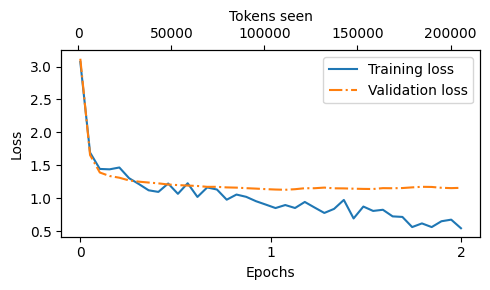

In [40]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-fineTunned.pth"
torch.save(modelFT.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-fineTunned.pth


In [ ]:
modelBase = GPTModel(BASE_CONFIG)
load_weights_into_gpt(modelBase, params)

<All keys matched successfully>

## Geração de resultados no test set(10%)

In [ ]:
import json
import torch
from tqdm import tqdm

torch.manual_seed(123)

modelBase.eval().to(device)
modelFT.eval().to(device)


results = []

for i in tqdm(range(len(test_data))):
    entry = test_data[i]
    input_text = format_input(entry)

    token_ids = generate(
        model=modelFT,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    token_ids_wft = generate(
        model=modelBase,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    generated_text_wft = token_ids_to_text(token_ids_wft, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    response_text_wft = (
        generated_text_wft[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    results.append({
        "instruction": entry["instruction"],
        "input": entry["input"],
        "output": entry["output"],
        "model 1 response": response_text,
        "model 2 response": response_text_wft
    })

with open("model_responses.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

100%|██████████| 100/100 [28:22<00:00, 17.03s/it]


In [ ]:
!pip -q install -U deepeval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-exporter-gcp-loggin

## LLM as a Judge
Nessa seção eu extraio e salvo os resultados (**model_response.json**) da LLM as a judge tanto do modelo base quanto do modelo full(1000 instruções), a extração e analise está no **analise.ipynb**

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

JSON_PATH = "/content/model_responses.json"  # ajuste
with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)
    data = data

def build_full_input(instruction: str, inp: str) -> str:
    instruction = (instruction or "").strip()
    inp = (inp or "").strip()
    if inp:
        return f"Instruction:\n{instruction}\n\nInput:\n{inp}"
    return f"Instruction:\n{instruction}"

_ws_re = re.compile(r"[ \t]+\n")

def normalize_text(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = _ws_re.sub("\n", s)
    return s.strip()

def de_repeat_blocks(text: str, max_repeat=2) -> str:
    t = normalize_text(text)
    if not t:
        return t

    parts = re.split(r"(?m)^\s*#{2,}\s*(Instruction|Input|Output|Answer|Result)\s*:?\s*$", t)
    if len(parts) < 5:
        return t

    lines = t.splitlines()
    out_lines = []
    last = None
    streak = 0
    for ln in lines:
        key = ln.strip()
        if key == last and key != "":
            streak += 1
            if streak >= max_repeat:
                continue
        else:
            last = key
            streak = 0
        out_lines.append(ln)
    return "\n".join(out_lines).strip()

def smart_truncate(text: str, max_chars=1200) -> str:
    t = normalize_text(text)
    if len(t) <= max_chars:
        return t
    head = t[:800]
    tail = t[-300:]
    return (head + "\n...\n" + tail).strip()

def clean_model_output(raw: str) -> str:
    t = normalize_text(raw)
    t = de_repeat_blocks(t, max_repeat=1)
    t = smart_truncate(t, max_chars=1200)
    return t

from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams

def to_0_5(score_0_1: float) -> float:
    score_0_1 = 0.0 if score_0_1 is None else float(score_0_1)
    score_0_1 = max(0.0, min(1.0, score_0_1))
    return round(score_0_1 * 5.0, 2)

factual_metric = GEval(
    name="FactualCorrectness",
    evaluation_steps=[
        "Use 'expected output' as the reference answer.",
        "Decide whether 'actual output' is factually consistent with the expected output.",
        "If actual output contradicts the expected output, score near 0.",
        "If it matches or is an equivalent correct answer, score near 1.",
        "Penalize major missing required facts when the task expects a concrete answer."
    ],
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.EXPECTED_OUTPUT,
    ],
)

adherence_metric = GEval(
    name="InstructionAdherence",
    evaluation_steps=[
        "Check whether the response follows the instruction and uses the provided input (if any).",
        "Penalize if it ignores the task, repeats templates, or outputs irrelevant content.",
        "If the instruction implies a specific format (e.g., classification label, rewrite, short answer), penalize deviations.",
        "Do NOT judge factual correctness here; only whether it follows the instruction."
    ],
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
    ],
)

clarity_metric = GEval(
    name="ClarityUtility",
    evaluation_steps=[
        "Assess whether the response is clear, concise, and useful for the user.",
        "Penalize repetition, boilerplate, excessive verbosity, or confusing structure.",
        "Reward direct answers with minimal noise.",
        "For simple tasks, the best response is short and unambiguous."
    ],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
)

def eval_one(model_name: str, ex: dict, raw_output: str, idx: int) -> dict:
    full_input = build_full_input(ex.get("instruction",""), ex.get("input",""))
    expected = normalize_text(ex.get("output",""))
    actual = clean_model_output(raw_output)

    tc = LLMTestCase(
        input=full_input,
        actual_output=actual,
        expected_output=expected,
    )

    factual_metric.measure(tc)
    adherence_metric.measure(tc)
    clarity_metric.measure(tc)

    return {
        "id": idx,
        "model": model_name,
        "instruction": ex.get("instruction",""),
        "input": ex.get("input",""),
        "expected_output": expected,
        "actual_output": actual,

        "factual_0_5": to_0_5(factual_metric.score),
        "adherence_0_5": to_0_5(adherence_metric.score),
        "clarity_0_5": to_0_5(clarity_metric.score),

        "factual_reason": factual_metric.reason,
        "adherence_reason": adherence_metric.reason,
        "clarity_reason": clarity_metric.reason,
    }

results = []

for i, ex in tqdm(list(enumerate(data)), total=len(data), desc="Evaluating"):
    results.append(eval_one("model_finetuned", ex, ex.get("model 1 response", ""), i))
    results.append(eval_one("model_base", ex, ex.get("model 2 response", ""), i))

df = pd.DataFrame(results)

summary = df.groupby("model")[["factual_0_5","adherence_0_5","clarity_0_5"]].mean().round(3)
display(summary)

OUT_BASE = "/content/deepeval_results_model_base.csv"
OUT_FINETUNED = "/content/deepeval_results_model_finetuned.csv"
OUT_JSONL = "/content/deepeval_results.jsonl"

df[df["model"] == "model_base"].to_csv(OUT_BASE, index=False)
df[df["model"] == "model_finetuned"].to_csv(OUT_FINETUNED, index=False)

with open(OUT_JSONL, "w", encoding="utf-8") as f:
    for row in results:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

print("Salvo em:")
print(OUT_BASE)
print(OUT_FINETUNED)
print(OUT_JSONL)

df["len_actual"] = df["actual_output"].str.len()
bad = df[(df["model"]=="model_finetuned") & (df["adherence_0_5"]<=1.0)].sort_values("len_actual", ascending=False).head(10)
display(bad[["id","factual_0_5","adherence_0_5","clarity_0_5","len_actual","instruction"]])


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

factual_0_5  adherence_0_5  clarity_0_5
model                                                   
model_base             0.180          0.243        0.897
model_finetuned        3.362          4.162        2.716

Salvo em:
/content/deepeval_results_model_base.csv
/content/deepeval_results_model_finetuned.csv
/content/deepeval_results.jsonl


id  factual_0_5  adherence_0_5  clarity_0_5  len_actual  \
136   68         0.53           1.00         1.25         133   
336  168         0.53           1.00         1.19         133   
140   70         0.00           1.00         0.37          59   
340  170         0.00           0.99         0.50          59   
170   85         0.11           0.37         3.76          53   
370  185         0.00           0.49         3.86          53   
118   59         0.01           1.00         0.55          47   
318  159         0.00           0.99         0.56          47   
198   99         0.13           0.50         4.38          46   
398  199         0.00           0.51         4.48          46   

                                           instruction  
136  Describe the process of active transport in ce...  
336  Describe the process of active transport in ce...  
140  Identify the type of triangle with angles of 9...  
340  Identify the type of triangle with angles of 9...  
170         Fill in the blanks with appropriate words.  
370         Fill in the blanks with appropriate words.  
118           What is the contraction for 'they will'?  
318           What is the contraction for 'they will'?  
198  Split the following sentence into two declarat...  
398  Split the following sentence into two declarat...